In [76]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
df = pd.read_csv('feature_selection_top_states.csv', parse_dates = True)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,...,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME
0,2020-03-01,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
1,2020-03-02,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2,2020-03-03,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,California
3,2020-03-04,1.0,1.0,0.0,112.5,0.0,1.0,1.0,0.0,0.0,...,873999,0.0,0.0,24.685185,1.860398,5.818187,1.71647,0.0,10,California
4,2020-03-05,1.0,1.0,0.0,112.5,0.0,1.0,1.0,1.0,0.0,...,873999,0.0,0.0,25.753086,1.860398,5.818187,1.71647,0.0,12,California


In [77]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
ca_df.head(3)

,Date,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,...,new_cases_100_mean,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT
0,2020-03-01,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,1107.65,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5
1,2020-03-02,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,1018.62,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5
2,2020-03-03,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,939.63,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7


In [78]:
#separate train & test sets
train_size = int(len(ca_df)* 0.80)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [79]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

# Keep the 'Date' column separate and not to be scaled or PCA-transformed
Date_train = X_ca_train[['Date']].reset_index(drop=True)
Date_test = X_ca_test[['Date']].reset_index(drop=True)

# Exclude the 'Date' column from scaling and PCA
X_train_ca_numerical = X_ca_train.drop(columns=['Date'])
X_test_ca_numerical = X_ca_test.drop(columns=['Date'])


#standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ca_numerical)
X_test_scaled = scaler.fit_transform(X_test_ca_numerical)

#PCA to reduce the features to the top 40 principal components 
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#transformed data `X_pca` has only the top 40 principal components now
X_train_pca_df = pd.DataFrame(data = X_train_pca)
X_test_pca_df = pd.DataFrame(data = X_test_pca)

# Concatenate the PCA components with the 'Date' column
X_train_final = pd.concat([Date_train, X_train_pca_df], axis=1)
X_test_final = pd.concat([Date_test, X_test_pca_df], axis=1)

In [80]:
#forward selection algorithm to determine optimal feature combination for multivariate prophet model
target_column = 'PEOPLE_POSITIVE_NEW_CASES_COUNT'

#forward selection function to include target data as separate arguments
def forward_selection(train_df, test_df, y_train, y_test, target_column):
    train_df.columns = train_df.columns.astype(str)
    test_df.columns = test_df.columns.astype(str)

    features = [col for col in train_df.columns if col != 'Date']
    included_features = []
    best_mae = np.inf
    improvement = True
    
    while improvement and features:
        improvement = False
        for feature in features:
            test_features = included_features + [feature]
            
            # Initialize and setup Prophet model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            for f in test_features:
                model.add_regressor(f, standardize=False)
                
            # Prepare training data
            train_data = train_df[['Date'] + test_features]
            train_data['y'] = y_train
            train_data = train_data.rename(columns={'Date': 'ds'})
            
            model.fit(train_data)
            
            # Prepare testing data
            test_data = test_df[['Date'] + test_features]
            test_data['y'] = y_test  # This line is not used for prediction but kept for consistency
            test_data = test_data.rename(columns={'Date': 'ds'})
            
            forecast = model.predict(test_data.drop(columns=['y']))
            
            # Evaluate the model
            mae = mean_absolute_error(y_test, forecast['yhat'])
            
            if mae < best_mae:
                best_feature = feature
                best_mae = mae
                improvement = True
                
        if improvement:
            included_features.append(best_feature)
            features.remove(best_feature)
            print(f"Added {best_feature} to the model, new best MAE: {best_mae}")
    
    print(f"Final features selected: {included_features}")
    return included_features

In [81]:
# Run the updated forward selection
selected_features = forward_selection(X_train_final, X_test_final, y_ca_train, y_ca_test, target_column)

12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing
12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:04 - cmdstanpy - INFO - Chain [1] done processing
12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing
12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing
12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing
12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1]

Added 7 to the model, new best MAE: 20549.660840240853


12:56:14 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1] done processing
12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing
12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing
12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing
12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing
12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing
12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing
12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing
12:56:16 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1]

Added 5 to the model, new best MAE: 20351.16012754798


12:56:25 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing
12:56:25 - cmdstanpy - INFO - Chain [1] start processing
12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing
12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing
12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing
12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1]

Added 8 to the model, new best MAE: 20214.87616663521


12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:36 - cmdstanpy - INFO - Chain [1] done processing
12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:36 - cmdstanpy - INFO - Chain [1] done processing
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing
12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing
12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1] done processing
12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:38 - cmdstanpy - INFO - Chain [1]

Added 24 to the model, new best MAE: 20084.83925789778


12:56:49 - cmdstanpy - INFO - Chain [1] done processing
12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:50 - cmdstanpy - INFO - Chain [1] done processing
12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing
12:56:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing
12:56:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing
12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:52 - cmdstanpy - INFO - Chain [1] done processing
12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:52 - cmdstanpy - INFO - Chain [1] done processing
12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:53 - cmdstanpy - INFO - Chain [1] done processing
12:56:53 - cmdstanpy - INFO - Chain [1] start processing
12:56:53 - cmdstanpy - INFO - Chain [1] done processing
12:56:53 - cmdstanpy - INFO - Chain [1] 

Added 31 to the model, new best MAE: 19949.909395603536


12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing
12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing
12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing
12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing
12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing
12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1] done processing
12:57:07 - cmdstanpy - INFO - Chain [1] 

Added 12 to the model, new best MAE: 19828.92683492242


12:57:16 - cmdstanpy - INFO - Chain [1] done processing
12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing
12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:18 - cmdstanpy - INFO - Chain [1] start processing
12:57:18 - cmdstanpy - INFO - Chain [1] done processing
12:57:18 - cmdstanpy - INFO - Chain [1] start processing
12:57:18 - cmdstanpy - INFO - Chain [1] done processing
12:57:18 - cmdstanpy - INFO - Chain [1] start processing
12:57:18 - cmdstanpy - INFO - Chain [1] done processing
12:57:19 - cmdstanpy - INFO - Chain [1] 

Added 10 to the model, new best MAE: 19719.94727148777


12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing
12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing
12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] 

Added 2 to the model, new best MAE: 19595.069019235732


12:57:40 - cmdstanpy - INFO - Chain [1] start processing
12:57:40 - cmdstanpy - INFO - Chain [1] done processing
12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:41 - cmdstanpy - INFO - Chain [1] done processing
12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:41 - cmdstanpy - INFO - Chain [1] done processing
12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing
12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing
12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing
12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing
12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing
12:57:43 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1]

Added 3 to the model, new best MAE: 19512.854023735592


12:57:51 - cmdstanpy - INFO - Chain [1] done processing
12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:52 - cmdstanpy - INFO - Chain [1] done processing
12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:52 - cmdstanpy - INFO - Chain [1] done processing
12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing
12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing
12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing
12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing
12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing
12:57:54 - cmdstanpy - INFO - Chain [1] start processing
12:57:54 - cmdstanpy - INFO - Chain [1] done processing
12:57:55 - cmdstanpy - INFO - Chain [1] 

Added 11 to the model, new best MAE: 19231.335803932634


12:58:02 - cmdstanpy - INFO - Chain [1] done processing
12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing
12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing
12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing
12:58:04 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing
12:58:04 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing
12:58:04 - cmdstanpy - INFO - Chain [1] start processing
12:58:05 - cmdstanpy - INFO - Chain [1] done processing
12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:05 - cmdstanpy - INFO - Chain [1] done processing
12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:05 - cmdstanpy - INFO - Chain [1] done processing
12:58:05 - cmdstanpy - INFO - Chain [1] 

Added 13 to the model, new best MAE: 19098.5704511411


12:58:13 - cmdstanpy - INFO - Chain [1] done processing
12:58:14 - cmdstanpy - INFO - Chain [1] start processing
12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:14 - cmdstanpy - INFO - Chain [1] start processing
12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:14 - cmdstanpy - INFO - Chain [1] start processing
12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:15 - cmdstanpy - INFO - Chain [1] done processing
12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:15 - cmdstanpy - INFO - Chain [1] done processing
12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:16 - cmdstanpy - INFO - Chain [1] done processing
12:58:16 - cmdstanpy - INFO - Chain [1] start processing
12:58:16 - cmdstanpy - INFO - Chain [1] done processing
12:58:16 - cmdstanpy - INFO - Chain [1] start processing
12:58:16 - cmdstanpy - INFO - Chain [1] done processing
12:58:16 - cmdstanpy - INFO - Chain [1] 

Added 30 to the model, new best MAE: 18970.602392777884


12:58:23 - cmdstanpy - INFO - Chain [1] done processing
12:58:24 - cmdstanpy - INFO - Chain [1] start processing
12:58:24 - cmdstanpy - INFO - Chain [1] done processing
12:58:24 - cmdstanpy - INFO - Chain [1] start processing
12:58:25 - cmdstanpy - INFO - Chain [1] done processing
12:58:25 - cmdstanpy - INFO - Chain [1] start processing
12:58:25 - cmdstanpy - INFO - Chain [1] done processing
12:58:26 - cmdstanpy - INFO - Chain [1] start processing
12:58:26 - cmdstanpy - INFO - Chain [1] done processing
12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing
12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing
12:58:28 - cmdstanpy - INFO - Chain [1] start processing
12:58:29 - cmdstanpy - INFO - Chain [1] done processing
12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing
12:58:31 - cmdstanpy - INFO - Chain [1] 

Added 22 to the model, new best MAE: 18877.090380586884


12:58:40 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing
12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:41 - cmdstanpy - INFO - Chain [1] done processing
12:58:41 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing
12:58:42 - cmdstanpy - INFO - Chain [1] start processing
12:58:42 - cmdstanpy - INFO - Chain [1] done processing
12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing
12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing
12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:44 - cmdstanpy - INFO - Chain [1] done processing
12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing
12:58:45 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1]

Added 21 to the model, new best MAE: 18855.866752201822


12:58:55 - cmdstanpy - INFO - Chain [1] start processing
12:58:55 - cmdstanpy - INFO - Chain [1] done processing
12:58:56 - cmdstanpy - INFO - Chain [1] start processing
12:58:56 - cmdstanpy - INFO - Chain [1] done processing
12:58:56 - cmdstanpy - INFO - Chain [1] start processing
12:58:56 - cmdstanpy - INFO - Chain [1] done processing
12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing
12:58:57 - cmdstanpy - INFO - Chain [1] start processing
12:58:57 - cmdstanpy - INFO - Chain [1] done processing
12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing
12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing
12:58:59 - cmdstanpy - INFO - Chain [1] start processing
12:58:59 - cmdstanpy - INFO - Chain [1] done processing
12:58:59 - cmdstanpy - INFO - Chain [1] start processing
12:58:59 - cmdstanpy - INFO - Chain [1]

Added 17 to the model, new best MAE: 18842.700188570107


12:59:08 - cmdstanpy - INFO - Chain [1] done processing
12:59:08 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing
12:59:09 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing
12:59:09 - cmdstanpy - INFO - Chain [1] start processing
12:59:10 - cmdstanpy - INFO - Chain [1] done processing
12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:10 - cmdstanpy - INFO - Chain [1] done processing
12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:10 - cmdstanpy - INFO - Chain [1] done processing
12:59:11 - cmdstanpy - INFO - Chain [1] start processing
12:59:11 - cmdstanpy - INFO - Chain [1] done processing
12:59:11 - cmdstanpy - INFO - Chain [1] start processing
12:59:11 - cmdstanpy - INFO - Chain [1] done processing
12:59:12 - cmdstanpy - INFO - Chain [1] start processing
12:59:12 - cmdstanpy - INFO - Chain [1] done processing
12:59:12 - cmdstanpy - INFO - Chain [1] 

Added 6 to the model, new best MAE: 18806.08785700683


12:59:19 - cmdstanpy - INFO - Chain [1] start processing
12:59:19 - cmdstanpy - INFO - Chain [1] done processing
12:59:20 - cmdstanpy - INFO - Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing
12:59:20 - cmdstanpy - INFO - Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing
12:59:20 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing
12:59:21 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing
12:59:21 - cmdstanpy - INFO - Chain [1] start processing
12:59:21 - cmdstanpy - INFO - Chain [1] done processing
12:59:22 - cmdstanpy - INFO - Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1] done processing
12:59:22 - cmdstanpy - INFO - Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1] done processing
12:59:22 - cmdstanpy - INFO - Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1]

Added 14 to the model, new best MAE: 18726.56509156482


12:59:29 - cmdstanpy - INFO - Chain [1] done processing
12:59:29 - cmdstanpy - INFO - Chain [1] start processing
12:59:29 - cmdstanpy - INFO - Chain [1] done processing
12:59:30 - cmdstanpy - INFO - Chain [1] start processing
12:59:30 - cmdstanpy - INFO - Chain [1] done processing
12:59:30 - cmdstanpy - INFO - Chain [1] start processing
12:59:30 - cmdstanpy - INFO - Chain [1] done processing
12:59:30 - cmdstanpy - INFO - Chain [1] start processing
12:59:31 - cmdstanpy - INFO - Chain [1] done processing
12:59:31 - cmdstanpy - INFO - Chain [1] start processing
12:59:31 - cmdstanpy - INFO - Chain [1] done processing
12:59:31 - cmdstanpy - INFO - Chain [1] start processing
12:59:32 - cmdstanpy - INFO - Chain [1] done processing
12:59:32 - cmdstanpy - INFO - Chain [1] start processing
12:59:32 - cmdstanpy - INFO - Chain [1] done processing
12:59:32 - cmdstanpy - INFO - Chain [1] start processing
12:59:32 - cmdstanpy - INFO - Chain [1] done processing
12:59:33 - cmdstanpy - INFO - Chain [1] 

Added 38 to the model, new best MAE: 18707.79334078957


12:59:42 - cmdstanpy - INFO - Chain [1] done processing
12:59:42 - cmdstanpy - INFO - Chain [1] start processing
12:59:42 - cmdstanpy - INFO - Chain [1] done processing
12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing
12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing
12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] 

Added 19 to the model, new best MAE: 18685.57572263121


12:59:56 - cmdstanpy - INFO - Chain [1] start processing
12:59:56 - cmdstanpy - INFO - Chain [1] done processing
12:59:57 - cmdstanpy - INFO - Chain [1] start processing
12:59:57 - cmdstanpy - INFO - Chain [1] done processing
12:59:58 - cmdstanpy - INFO - Chain [1] start processing
12:59:58 - cmdstanpy - INFO - Chain [1] done processing
12:59:58 - cmdstanpy - INFO - Chain [1] start processing
12:59:59 - cmdstanpy - INFO - Chain [1] done processing
12:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing
13:00:00 - cmdstanpy - INFO - Chain [1] start processing
13:00:00 - cmdstanpy - INFO - Chain [1] done processing
13:00:01 - cmdstanpy - INFO - Chain [1] start processing
13:00:01 - cmdstanpy - INFO - Chain [1] done processing
13:00:01 - cmdstanpy - INFO - Chain [1] start processing
13:00:01 - cmdstanpy - INFO - Chain [1] done processing
13:00:02 - cmdstanpy - INFO - Chain [1] start processing
13:00:02 - cmdstanpy - INFO - Chain [1]

Added 34 to the model, new best MAE: 18662.38728871035


13:00:07 - cmdstanpy - INFO - Chain [1] done processing
13:00:08 - cmdstanpy - INFO - Chain [1] start processing
13:00:08 - cmdstanpy - INFO - Chain [1] done processing
13:00:08 - cmdstanpy - INFO - Chain [1] start processing
13:00:08 - cmdstanpy - INFO - Chain [1] done processing
13:00:09 - cmdstanpy - INFO - Chain [1] start processing
13:00:09 - cmdstanpy - INFO - Chain [1] done processing
13:00:09 - cmdstanpy - INFO - Chain [1] start processing
13:00:09 - cmdstanpy - INFO - Chain [1] done processing
13:00:09 - cmdstanpy - INFO - Chain [1] start processing
13:00:10 - cmdstanpy - INFO - Chain [1] done processing
13:00:10 - cmdstanpy - INFO - Chain [1] start processing
13:00:10 - cmdstanpy - INFO - Chain [1] done processing
13:00:10 - cmdstanpy - INFO - Chain [1] start processing
13:00:11 - cmdstanpy - INFO - Chain [1] done processing
13:00:11 - cmdstanpy - INFO - Chain [1] start processing
13:00:11 - cmdstanpy - INFO - Chain [1] done processing
13:00:11 - cmdstanpy - INFO - Chain [1] 

Added 16 to the model, new best MAE: 18607.67326135591


13:00:16 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing
13:00:17 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing
13:00:17 - cmdstanpy - INFO - Chain [1] done processing
13:00:17 - cmdstanpy - INFO - Chain [1] start processing
13:00:17 - cmdstanpy - INFO - Chain [1] done processing
13:00:18 - cmdstanpy - INFO - Chain [1] start processing
13:00:18 - cmdstanpy - INFO - Chain [1] done processing
13:00:18 - cmdstanpy - INFO - Chain [1] start processing
13:00:18 - cmdstanpy - INFO - Chain [1] done processing
13:00:19 - cmdstanpy - INFO - Chain [1] start processing
13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:19 - cmdstanpy - INFO - Chain [1] start processing
13:00:19 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] start processing
13:00:20 - cmdstanpy - INFO - Chain [1] done processing
13:00:20 - cmdstanpy - INFO - Chain [1] 

Added 28 to the model, new best MAE: 18569.736166286642


13:00:24 - cmdstanpy - INFO - Chain [1] done processing
13:00:24 - cmdstanpy - INFO - Chain [1] start processing
13:00:25 - cmdstanpy - INFO - Chain [1] done processing
13:00:25 - cmdstanpy - INFO - Chain [1] start processing
13:00:25 - cmdstanpy - INFO - Chain [1] done processing
13:00:25 - cmdstanpy - INFO - Chain [1] start processing
13:00:25 - cmdstanpy - INFO - Chain [1] done processing
13:00:26 - cmdstanpy - INFO - Chain [1] start processing
13:00:26 - cmdstanpy - INFO - Chain [1] done processing
13:00:26 - cmdstanpy - INFO - Chain [1] start processing
13:00:26 - cmdstanpy - INFO - Chain [1] done processing
13:00:27 - cmdstanpy - INFO - Chain [1] start processing
13:00:27 - cmdstanpy - INFO - Chain [1] done processing
13:00:27 - cmdstanpy - INFO - Chain [1] start processing
13:00:27 - cmdstanpy - INFO - Chain [1] done processing
13:00:27 - cmdstanpy - INFO - Chain [1] start processing
13:00:27 - cmdstanpy - INFO - Chain [1] done processing
13:00:28 - cmdstanpy - INFO - Chain [1] 

Final features selected: ['7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']


In [84]:
train_final = pd.concat([X_train_final, y_ca_train], axis = 1)

#reset the index of both test dfs to ensure they align correctly
X_test_reset = X_test_final.reset_index(drop=True)
y_test_reset = y_ca_test.reset_index(drop=True)

#concat the dfs side by side using the reset indexes
test_final = pd.concat([X_test_reset, y_test_reset], axis=1)

In [85]:
train_final = train_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
test_final = test_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [86]:
# Combine them vertically
full_df = pd.concat([train_final, test_final], ignore_index=True)

MULTIVARIATE PROPHET MODEL WITH VARIABLES REVEALED VIA FORWARD SELECTION

In [87]:
#initialize model with seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

#add each regressor individually
regressor_names = ['7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']
for name in regressor_names:
    model_multivariate.add_regressor(name, standardize=False)

model_multivariate.fit(train_final)


13:02:13 - cmdstanpy - INFO - Chain [1] start processing
13:02:13 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
#create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=158)

#append the regressor values
future_multivariate = pd.merge(future_multivariate, full_df[['ds', '7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']], on='ds', how='inner')

#fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
future_multivariate.tail(5)

,ds,7,5,8,24,31,12,10,2,3,...,22,21,17,6,14,38,19,34,16,28
785,2022-04-25,0.048349,0.005434,-0.443623,0.131912,0.015781,0.033898,-0.273876,-2.946713,0.944813,...,-0.112358,-0.249212,-0.102091,-0.252559,0.477102,-1.118808e-17,0.110402,1.905705e-16,-0.218173,0.021292
786,2022-04-26,-0.022715,-0.121562,-0.576525,0.126612,0.032555,0.040233,-0.041775,-2.909375,0.877714,...,-0.190164,-0.246183,0.163501,-0.515209,0.564108,-1.472127e-16,0.065670,2.455289e-16,-0.239107,-0.002740
787,2022-04-27,0.185175,0.168992,-0.847481,0.174647,-0.002545,-0.097051,0.014247,-2.926215,0.870881,...,-0.226299,-0.279431,-0.122057,-0.452214,0.184392,3.296517e-17,-0.054527,2.024347e-16,-0.298359,0.003485
788,2022-04-28,0.634229,0.748392,0.463759,0.157598,-0.000873,-0.516282,0.654931,-3.092825,0.682665,...,-0.253847,-0.261083,0.072365,1.204788,0.310898,1.317295e-16,-0.238967,2.020656e-16,-0.300357,0.056692
789,2022-04-29,0.245134,0.309418,-0.351768,0.263437,-0.016358,-0.465332,-0.228421,-3.033552,0.801140,...,-0.246962,-0.341102,0.070769,-0.025944,0.154211,4.233152e-17,-0.086056,2.406716e-16,-0.313348,0.016716


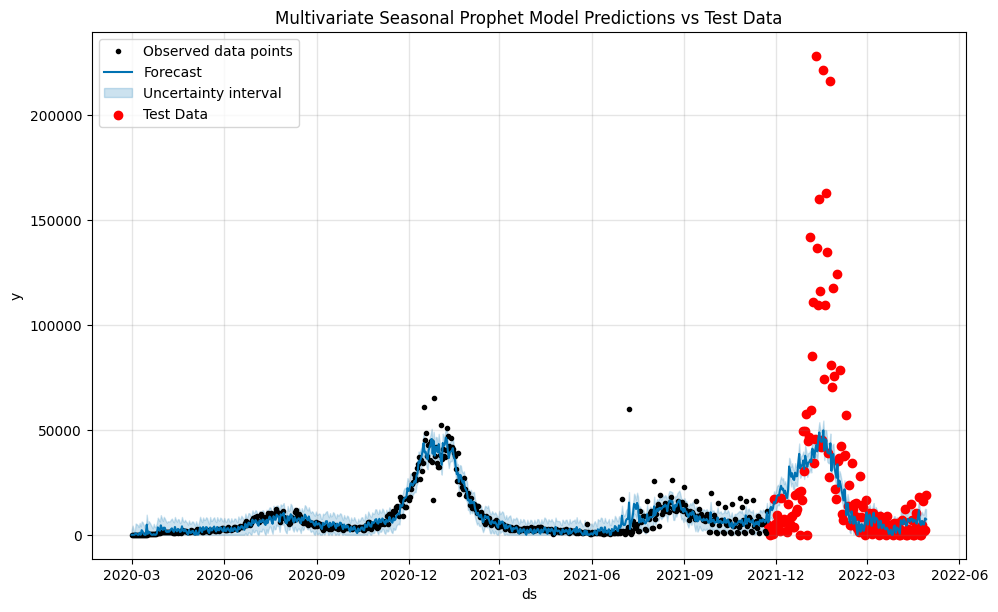

In [93]:
#make predictions
forecast_multivariate = model_multivariate.predict(future_multivariate)
#update negative predictions to 0
forecast_multivariate['yhat'] = forecast_multivariate['yhat'].clip(lower=0)
forecast_multivariate['yhat_lower'] = forecast_multivariate['yhat_lower'].clip(lower=0)

#visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart
plt.scatter(test_final['ds'], test_final['y'], color='red', label='Test Data')
plt.title('Multivariate Seasonal Prophet Model Predictions vs Test Data')
plt.legend()
plt.show()

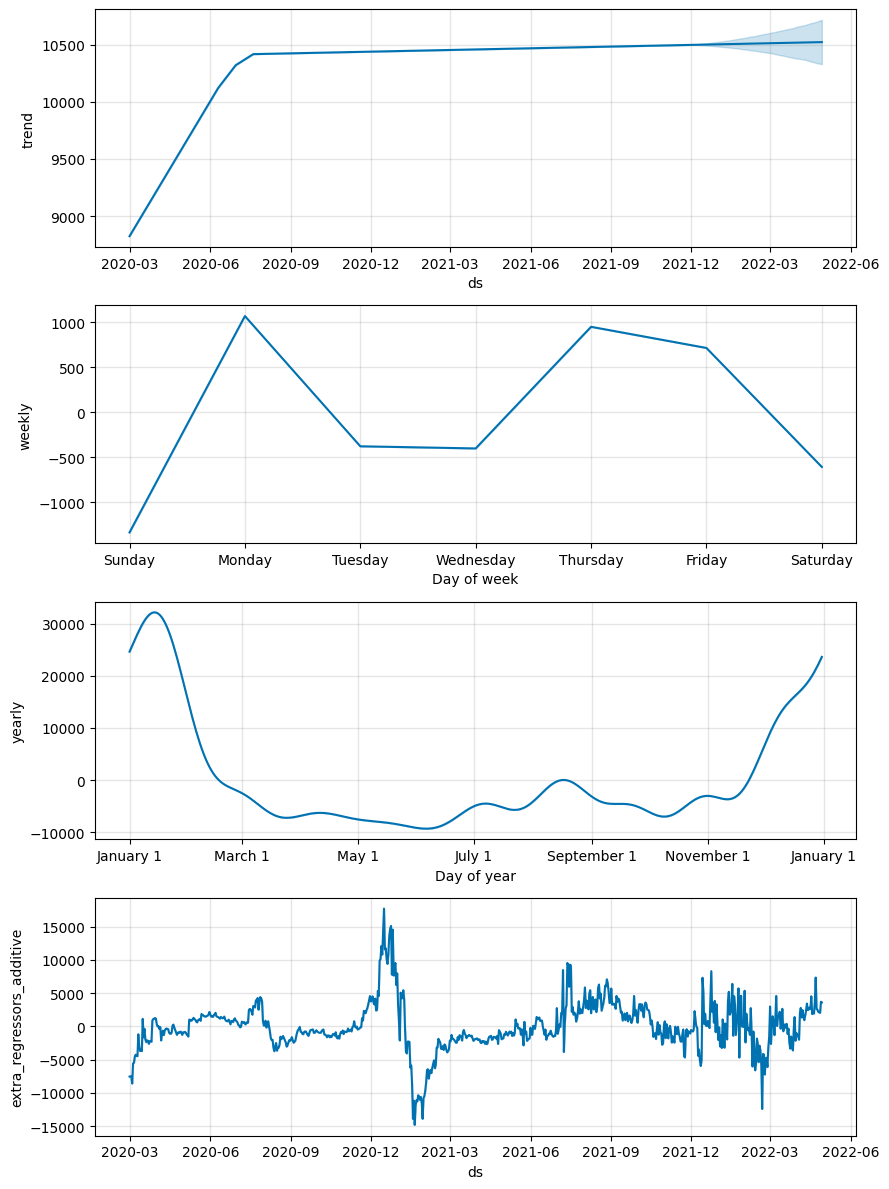

In [94]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [95]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test_final, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-158:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
#naive forecast for mase calculation
naive_forecast = test_final['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(test_final['y'][1:], naive_forecast.dropna())
mase = performance_multivariate_MAE / mae_naive

#calculate performance metrics
mae = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
mse = mean_squared_error(performance_multivariate['y'], performance_multivariate['yhat'])
rmse = np.sqrt(mse)
print(f'Non-holiday Test MAE: ', performance_multivariate_MAE)
print('Non-holiday Test RMSE: ', rmse)
print('Non-holiday Test MASE: ', mase)

Non-holiday Test MAE:  18530.687001651782
Non-holiday Test RMSE:  36645.40028810772
Non-holiday Test MASE:  0.9410751601284335


MODEL WITH HOLIDAY AND EVENT EFFECTS

In [96]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [97]:
model_holiday = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = events)

#add each regressor individually
regressor_names = ['7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']
for name in regressor_names:
    model_holiday.add_regressor(name, standardize=False)

model_holiday.fit(train_final)

model_holiday.train_holiday_names

13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing


0        COVID
1    superbowl
dtype: object

In [98]:
#create the time range for the forecast
future_multivariate_holiday = model_holiday.make_future_dataframe(periods=158)

#append the regressor values
future_multivariate_holiday = pd.merge(future_multivariate_holiday, full_df[['ds', '7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']], on='ds', how='inner')

#fill the missing values with the previous value
future_multivariate_holiday = future_multivariate_holiday.fillna(method='ffill')
future_multivariate.tail(5)

,ds,7,5,8,24,31,12,10,2,3,...,22,21,17,6,14,38,19,34,16,28
785,2022-04-25,0.048349,0.005434,-0.443623,0.131912,0.015781,0.033898,-0.273876,-2.946713,0.944813,...,-0.112358,-0.249212,-0.102091,-0.252559,0.477102,-1.118808e-17,0.110402,1.905705e-16,-0.218173,0.021292
786,2022-04-26,-0.022715,-0.121562,-0.576525,0.126612,0.032555,0.040233,-0.041775,-2.909375,0.877714,...,-0.190164,-0.246183,0.163501,-0.515209,0.564108,-1.472127e-16,0.065670,2.455289e-16,-0.239107,-0.002740
787,2022-04-27,0.185175,0.168992,-0.847481,0.174647,-0.002545,-0.097051,0.014247,-2.926215,0.870881,...,-0.226299,-0.279431,-0.122057,-0.452214,0.184392,3.296517e-17,-0.054527,2.024347e-16,-0.298359,0.003485
788,2022-04-28,0.634229,0.748392,0.463759,0.157598,-0.000873,-0.516282,0.654931,-3.092825,0.682665,...,-0.253847,-0.261083,0.072365,1.204788,0.310898,1.317295e-16,-0.238967,2.020656e-16,-0.300357,0.056692
789,2022-04-29,0.245134,0.309418,-0.351768,0.263437,-0.016358,-0.465332,-0.228421,-3.033552,0.801140,...,-0.246962,-0.341102,0.070769,-0.025944,0.154211,4.233152e-17,-0.086056,2.406716e-16,-0.313348,0.016716


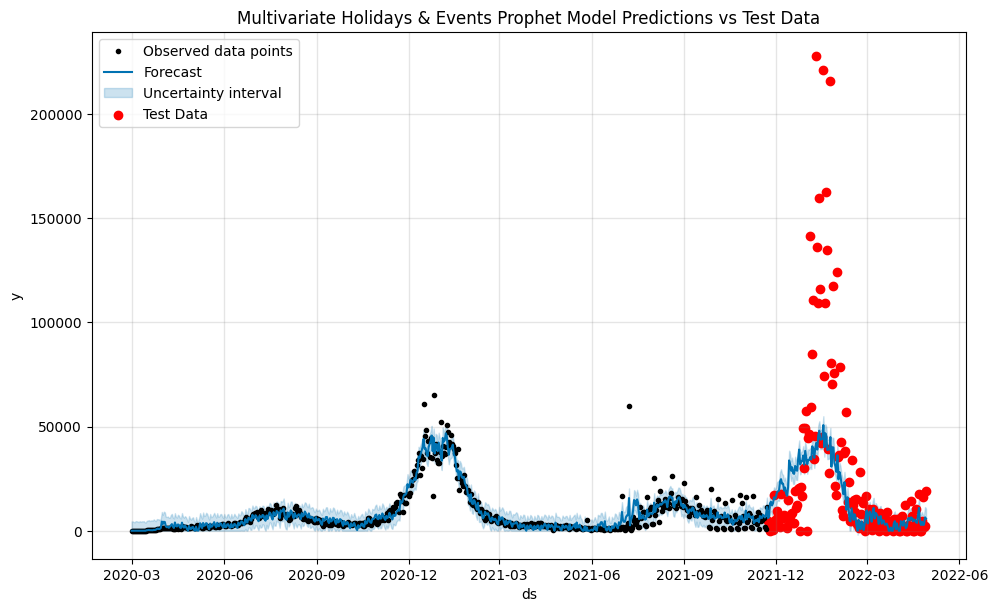

In [99]:
#make predictions
forecast_holiday = model_holiday.predict(future_multivariate_holiday)
#change negative predictions to 0
forecast_holiday['yhat'] = forecast_holiday['yhat'].clip(lower=0)

forecast_holiday['yhat_lower'] = forecast_holiday['yhat_lower'].clip(lower=0)
model_holiday.plot(forecast_holiday);
#overlay the actual test data
plt.scatter(test_final['ds'], test_final['y'], color='red', label='Test Data')
plt.title('Multivariate Holidays & Events Prophet Model Predictions vs Test Data')
plt.legend()

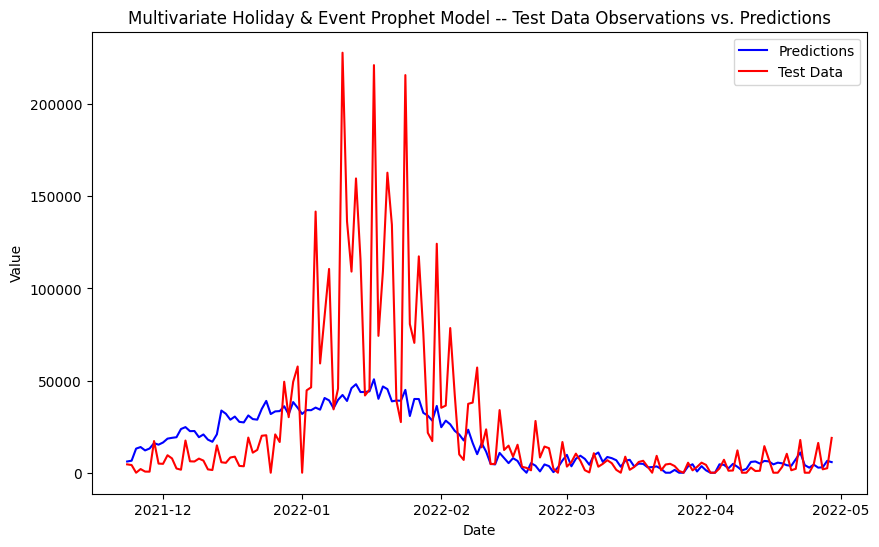

In [101]:
#predictions are already made in forecast_holiday
test_period_start = test_final['ds'].min()
test_period_end = test_final['ds'].max()
forecast_test_period = forecast_holiday[(forecast_holiday['ds'] >= test_period_start)]

#plot the predictions for the test period
plt.figure(figsize=(10, 6))
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Predictions', color='blue')

#overlay the actual test data
plt.plot(test_final['ds'], test_final['y'], color='red', label='Test Data')

plt.legend()
plt.title('Multivariate Holiday & Event Prophet Model -- Test Data Observations vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


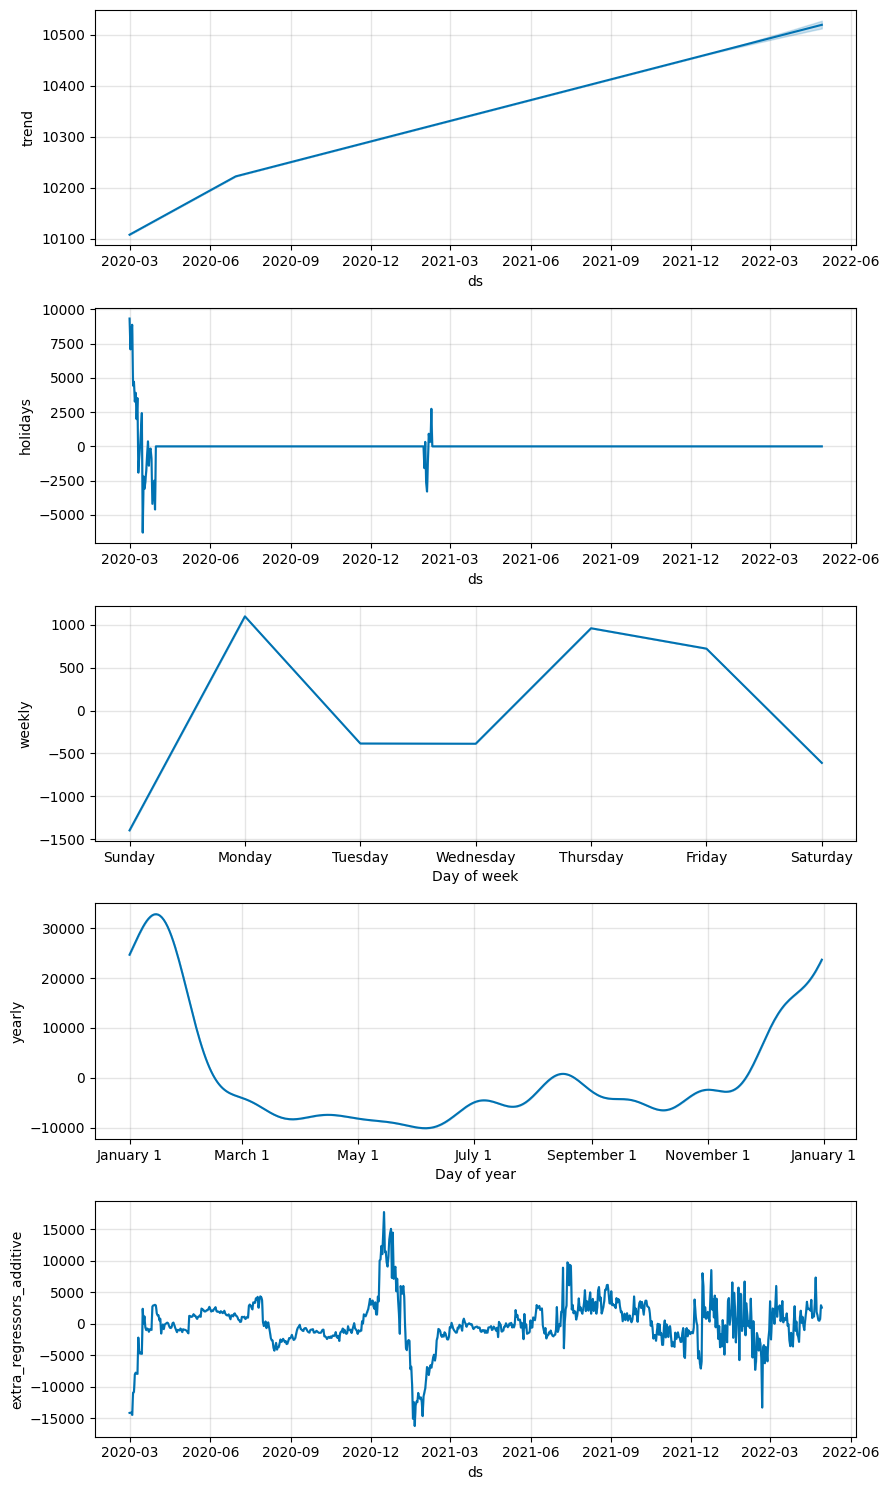

In [102]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

In [103]:
# Merge actual and predicted values
performance_holiday = pd.merge(test_final, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-158:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])

#performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
#print(f'Test MAPE {performance_holiday_MAPE}')

#naive forecast for mase calculation
naive_forecast = test_final['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(test_final['y'][1:], naive_forecast.dropna())
mase = performance_holiday_MAE / mae_naive

#calculate performance metrics
mae = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
mse = mean_squared_error(performance_holiday['y'], performance_holiday['yhat'])
rmse = np.sqrt(mse)
print(f'Holiday Model Test MAE: ', performance_holiday_MAE)
print('Holiday Model Test RMSE: ', rmse)
print('Holiday Model Test MASE: ', mase)


Holiday Model Test MAE:  18508.582780680124
Holiday Model Test RMSE:  36593.23039964472
Holiday Model Test MASE:  0.9399526041601328


HYPERPARAMETER TUNING

In [105]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
best_score = np.inf
best_params = None

for params in ParameterGrid(param_grid):
    scores = []
    for train_idx, test_idx in tscv.split(full_df):
        train = full_df.iloc[train_idx]
        test = full_df.iloc[test_idx]

        model = Prophet(**params, yearly_seasonality = True, weekly_seasonality = True, holidays = events).fit(train)
        forecast = model.predict(test[['ds']])
        #change negative predictions to 0
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
        
        score = mean_squared_error(test['y'], forecast['yhat'])
        scores.append(score)

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print(f"Best Parameters: {best_params}")

13:16:35 - cmdstanpy - INFO - Chain [1] start processing


13:16:35 - cmdstanpy - INFO - Chain [1] done processing
13:16:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:16:35 - cmdstanpy - INFO - Chain [1] start processing
13:16:36 - cmdstanpy - INFO - Chain [1] done processing
13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing
13:16:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:38 - cmdstanpy - INFO - Chain [1] done processing
13:16:39 - cmdstanpy - INFO - Chain [1] start processing
13:16:39 - cmdstanpy - INFO - Chain [1] done processing
13:16:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:16:39 - cmdstanpy - I

Best Parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


In [106]:
#tuned model 
tuned_model = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = events, changepoint_prior_scale = 0.001, holidays_prior_scale = 0.1, seasonality_mode = 'additive', seasonality_prior_scale = 0.1)

regressor_names = ['7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']
for name in regressor_names:
    tuned_model.add_regressor(name, standardize=False)

tuned_model.fit(train_final)

13:23:48 - cmdstanpy - INFO - Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
#create the time range for the forecast
future_multivariate_holiday_tuned = tuned_model.make_future_dataframe(periods=158)

#append the regressor values
future_multivariate_holiday_tuned = pd.merge(future_multivariate_holiday_tuned, full_df[['ds', '7', '5', '8', '24', '31', '12', '10', '2', '3', '11', '13', '30', '22', '21', '17', '6', '14', '38', '19', '34', '16', '28']], on='ds', how='inner')

#fill the missing values with the previous value
future_multivariate_holiday_tuned = future_multivariate_holiday_tuned.fillna(method='ffill')
future_multivariate_holiday_tuned.tail(5)

,ds,7,5,8,24,31,12,10,2,3,...,22,21,17,6,14,38,19,34,16,28
785,2022-04-25,0.048349,0.005434,-0.443623,0.131912,0.015781,0.033898,-0.273876,-2.946713,0.944813,...,-0.112358,-0.249212,-0.102091,-0.252559,0.477102,-1.118808e-17,0.110402,1.905705e-16,-0.218173,0.021292
786,2022-04-26,-0.022715,-0.121562,-0.576525,0.126612,0.032555,0.040233,-0.041775,-2.909375,0.877714,...,-0.190164,-0.246183,0.163501,-0.515209,0.564108,-1.472127e-16,0.065670,2.455289e-16,-0.239107,-0.002740
787,2022-04-27,0.185175,0.168992,-0.847481,0.174647,-0.002545,-0.097051,0.014247,-2.926215,0.870881,...,-0.226299,-0.279431,-0.122057,-0.452214,0.184392,3.296517e-17,-0.054527,2.024347e-16,-0.298359,0.003485
788,2022-04-28,0.634229,0.748392,0.463759,0.157598,-0.000873,-0.516282,0.654931,-3.092825,0.682665,...,-0.253847,-0.261083,0.072365,1.204788,0.310898,1.317295e-16,-0.238967,2.020656e-16,-0.300357,0.056692
789,2022-04-29,0.245134,0.309418,-0.351768,0.263437,-0.016358,-0.465332,-0.228421,-3.033552,0.801140,...,-0.246962,-0.341102,0.070769,-0.025944,0.154211,4.233152e-17,-0.086056,2.406716e-16,-0.313348,0.016716


In [108]:
#make predictions
forecast_tuned = tuned_model.predict(future_multivariate_holiday_tuned)
#change negative predictions to 0
forecast_tuned['yhat'] = forecast_tuned['yhat'].clip(lower=0)

forecast_tuned['yhat_lower'] = forecast_tuned['yhat_lower'].clip(lower=0)

In [109]:
# Merge actual and predicted values
performance_tuned = pd.merge(test_final, forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-158:], on='ds')

# Check MAE value
performance_tuned_MAE = mean_absolute_error(performance_tuned['y'], performance_tuned['yhat'])

#naive forecast for mase calculation
naive_forecast = test_final['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(test_final['y'][1:], naive_forecast.dropna())
mase = performance_tuned_MAE / mae_naive

#calculate performance metrics
mse = mean_squared_error(performance_tuned['y'], performance_tuned['yhat'])
rmse = np.sqrt(mse)
print(f'Tuned Model Test MAE: ', performance_tuned_MAE)
print('Tuned Model Test RMSE: ', rmse)
print('Tuned Model Test MASE: ', mase)


Tuned Model Test MAE:  21575.572886522732
Tuned Model Test RMSE:  37778.579853097
Tuned Model Test MASE:  1.095708740169061


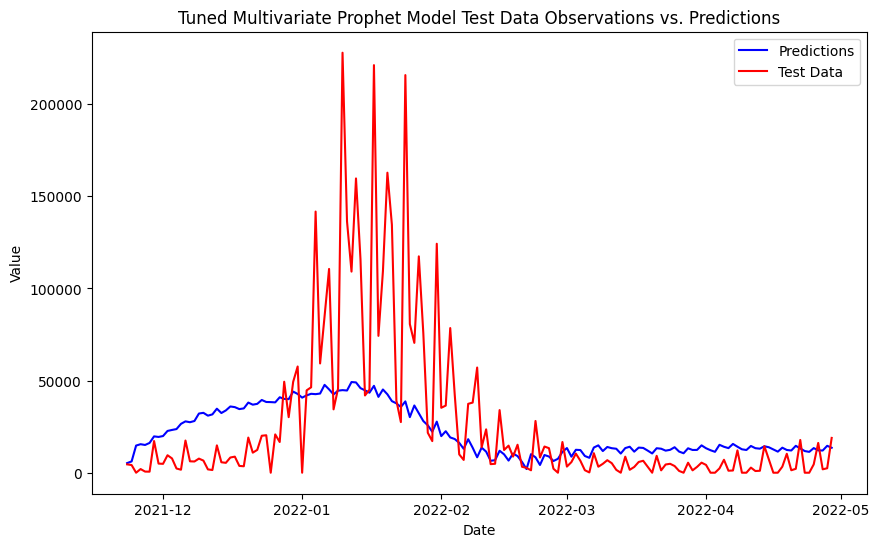

In [110]:
#predictions are already made in forecast_holiday, you need to filter this for the test period
test_period_start = test_final['ds'].min()
test_period_end = test_final['ds'].max()
forecast_test_period = forecast_tuned[(forecast_tuned['ds'] >= test_period_start)]

#plot the predictions for the test period
plt.figure(figsize=(10, 6))
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Predictions', color='blue')

#overlay the actual test data
plt.plot(test_final['ds'], test_final['y'], color='red', label='Test Data')
plt.legend()
plt.title('Tuned Multivariate Prophet Model Test Data Observations vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
